# Load data

<https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29>

In [1]:
import sage
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

In [3]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

# Train model

In [4]:
import numpy as np
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier

In [5]:
model = CatBoostClassifier(iterations=50,
                           learning_rate=0.3,
                           depth=3)

model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val),
                  verbose=False)

In [6]:
# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


# Calculate feature importance

In [7]:
# Setup and calculate
imputer = sage.MarginalImputer(train[:512])
sampler = sage.PermutationSampler(model, imputer, 'cross entropy')
sage_values = sampler(test, Y_test)

Estimating convergence time
Batch size = batch * samples = 262144


StdDev Ratio = 0.0865 (Converge at 0.0500)
StdDev Ratio = 0.0658 (Converge at 0.0500)
StdDev Ratio = 0.0597 (Converge at 0.0500)
StdDev Ratio = 0.0516 (Converge at 0.0500)
StdDev Ratio = 0.0468 (Converge at 0.0500)
Detected convergence



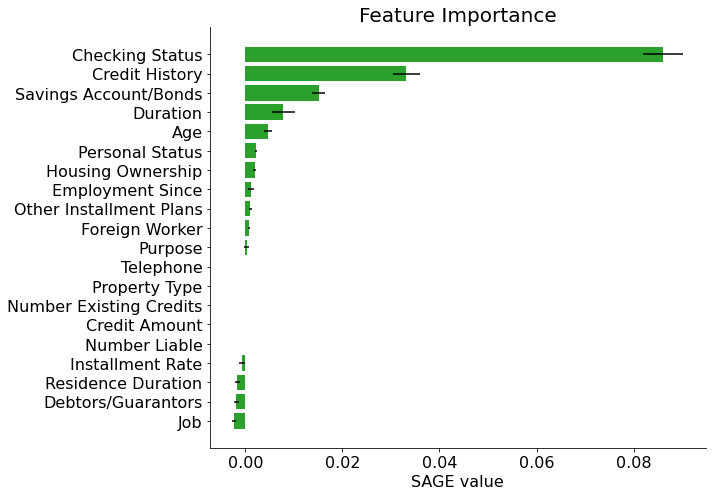

In [8]:
# Plot results
sage_values.plot(feature_names)

# Calculate model sensitivity (no labels)

In [9]:
# Setup and calculate
imputer = sage.MarginalImputer(train[:512])
sampler = sage.PermutationSampler(model, imputer, 'cross entropy')
sensitivity = sampler(test)

Using model output to calculate sensitivity
Estimating convergence time
Batch size = batch * samples = 262144


StdDev Ratio = 0.0493 (Converge at 0.0500)
Detected convergence



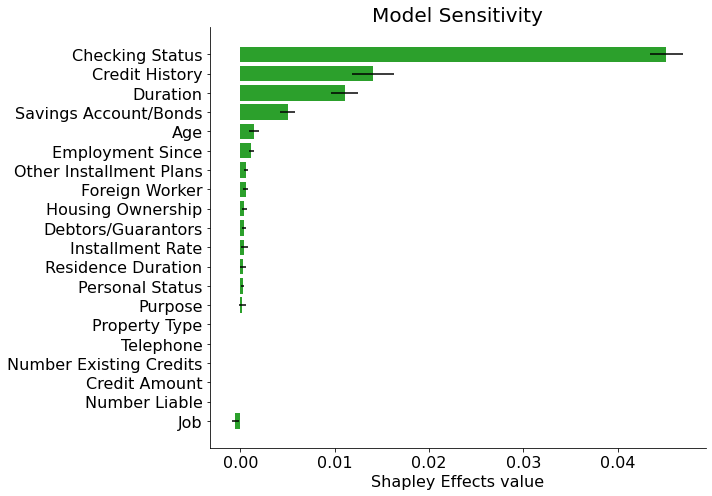

In [10]:
# Plot results
sensitivity.plot(feature_names, title='Model Sensitivity')